#### For this problem set I worked with Eugene Leypunskiy

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from matplotlib import gridspec
import scipy.io
import random

data = scipy.io.loadmat('/project/cmsc25025/sparsecoding/IMAGES_RAW.mat')
images = data['IMAGESr']

In [10]:
# All the functions to be used

def sample_random_patches(image, num, width):
    patches = np.zeros([width, width, num])
    for k in range(num):
        i, j = random.sample(range(image.shape[0]-width),2)
        patches[:,:,k] = image[i:i+width,j:j+width]
    return patches

def calc_codebook_beta(data, residual, codeBook, indexList, betaList):
    codeWord = np.argmax(np.abs(np.dot(residual.T, codeBook))/np.linalg.norm(codeBook, ord=2, axis=0))
    if codeWord in indexList:
        for i in np.argsort(-np.abs(np.dot(residual.T, codeBook))/np.linalg.norm(codeBook, ord=2, axis=0))[0]:
            if i in indexList:
                continue
            else:
                codeWord = i
                beta = np.dot(residual.T, np.array([codeBook[:,codeWord]]).T)
                newResidual = residual - beta * np.array([codeBook[:,codeWord]]).T
                indexList.append(codeWord)
                betaList[codeWord] = [beta[0][0]]
                return indexList, betaList, newResidual
                break
    else:
        beta = np.dot(residual.T, np.array([codeBook[:,codeWord]]).T)
        indexList.append(codeWord)
        betaList[codeWord] = [beta[0][0]]
        newResidual = residual - beta * np.array([codeBook[:,codeWord]]).T
        return indexList, betaList, newResidual

# SGD for codebook

def update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize):
    numData = len(allBetaList[0])
    stepsize = stepsize
    for indexList in allIndexList:
        for index in indexList:
            Xj = np.array([codeBook[:,index]]).T
            for i in range(numData):
                yi = np.array([dataMatrix[:,i]]).T 
                Xbi = np.dot(codeBook, np.array([allBetaList[:,i]]).T)
                bji = np.array(allBetaList[:,i])[index]
                gj = - np.dot(bji, (yi - Xbi))
                if i == 0:
                    sumGj = gj
                else:
                    sumGj = sumGj + gj
            newXj = Xj - ( np.dot(stepsize, sumGj) / float(numData) )
            newXj = newXj.T / np.linalg.norm(newXj.T)
            codeBook[:,index] = newXj

    return codeBook

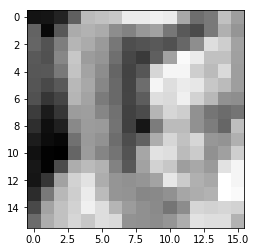

In [12]:
samplePatches = sample_random_patches(images[:,:,0], 1, 16)
plt.imshow(samplePatches[:,:,0], cmap='gray')

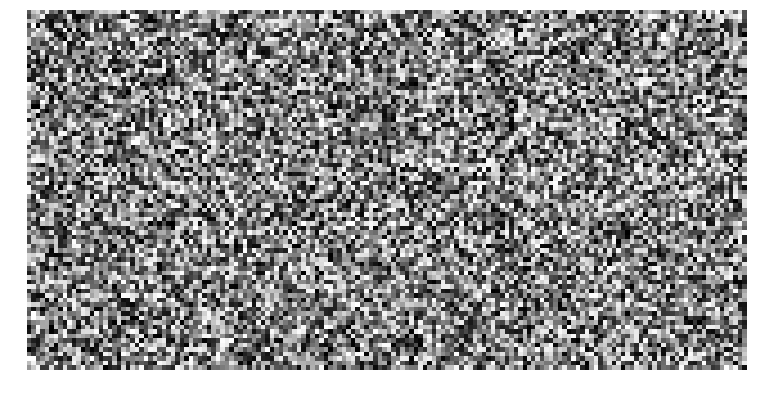

In [13]:
# initialize codeBook with the size of 256 x 50

codeBook = np.random.rand(256,50)
normCodeBook = np.linalg.norm(codeBook, axis=0)
codeBook = codeBook / normCodeBook

# Initial codeBook

#Plot my initial codebook which is 500 of 16 x 16 patches.
nrow = 5
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

## Experimenting with step size

### Step size = 0.001, 1, 1000 with 50 SGD iterations

stepsize = 0.001

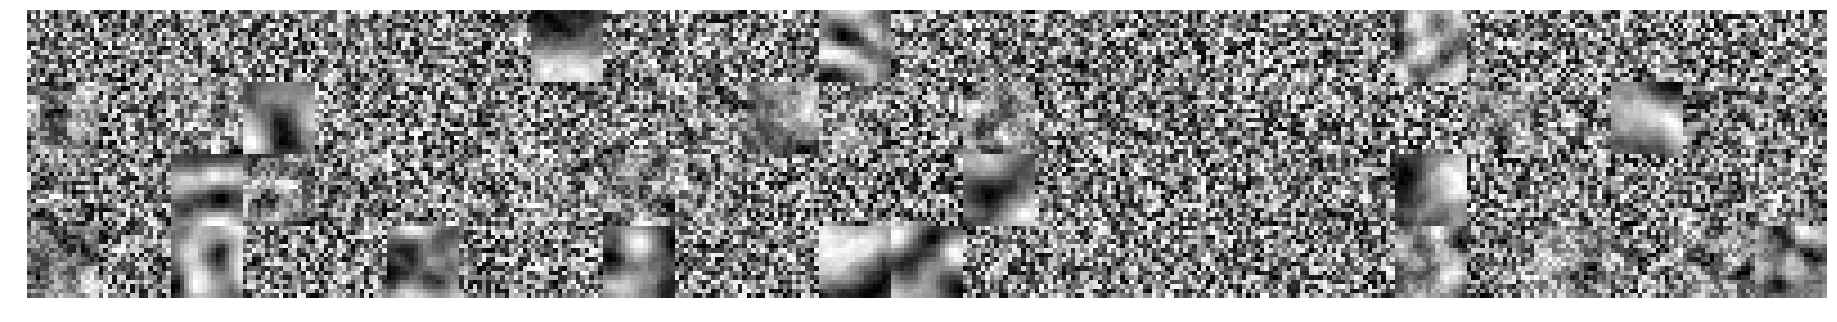

In [17]:
# initialize codeBook with the size of 256 x 100

codeBook = np.random.rand(256,100)
normCodeBook = np.linalg.norm(codeBook, axis=0)
codeBook = codeBook / normCodeBook

for i in xrange(500):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 200
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.001)

#Plot my initial codebook which is 200 of 16 x 16 patches.
nrow = 4
ncol = 25

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

stepsize = 1.0

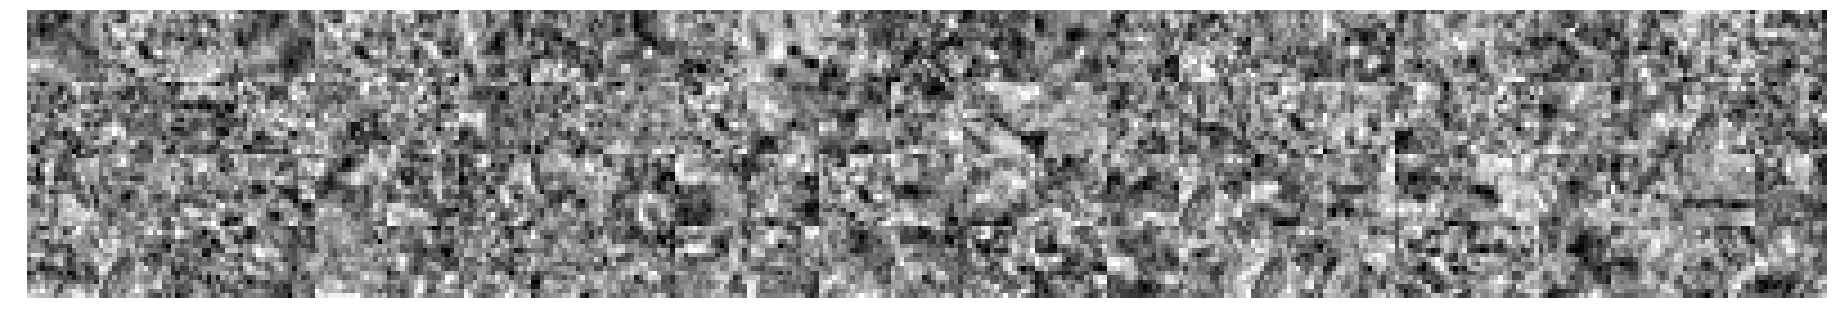

In [18]:
# initialize codeBook with the size of 256 x 50

codeBook = np.random.rand(256,100)
normCodeBook = np.linalg.norm(codeBook, axis=0)
codeBook = codeBook / normCodeBook

for i in xrange(500):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 200
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=1.)

#Plot my initial codebook which is 200 of 16 x 16 patches.
nrow = 4
ncol = 25

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

stepsize = 100

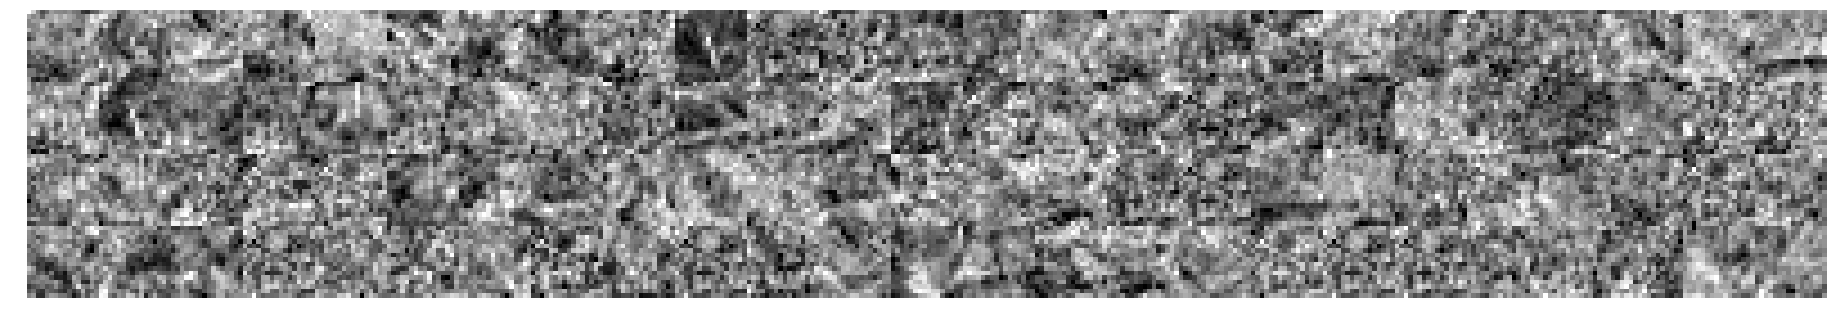

In [19]:
# initialize codeBook with the size of 256 x 50

codeBook = np.random.rand(256,100)
normCodeBook = np.linalg.norm(codeBook, axis=0)
codeBook = codeBook / normCodeBook

for i in xrange(500):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 200
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=100)

#Plot my initial codebook which is 200 of 16 x 16 patches.
nrow = 4
ncol = 25

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

## Let's SGD with 250,000 iterations with stepsize =0.0001 and codebook size of 40 and print out the first five 10,000 step increments.

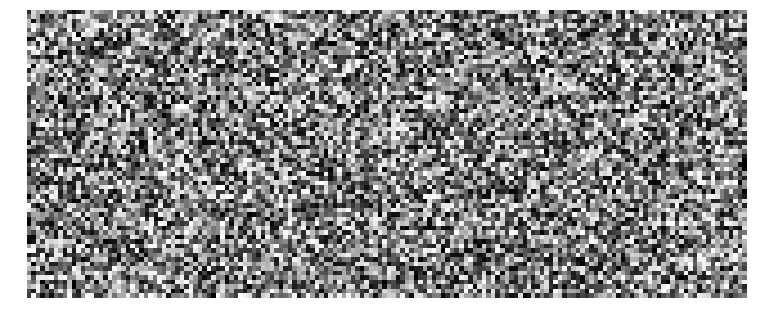

In [170]:
# Initializing a new codebook size 256 x 40
# Plotting the initial codebook 

codeBook = np.random.rand(256,40)
normCodeBook = np.linalg.norm(codeBook, axis=0)
codeBook = codeBook / normCodeBook

#Plot my initial codebook which is 200 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

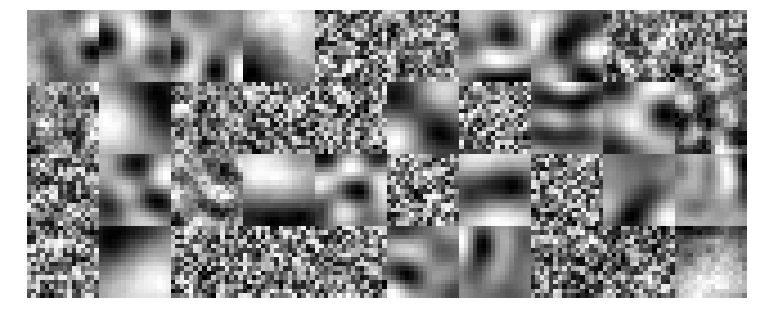

In [172]:
for i in xrange(10000):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.0001)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

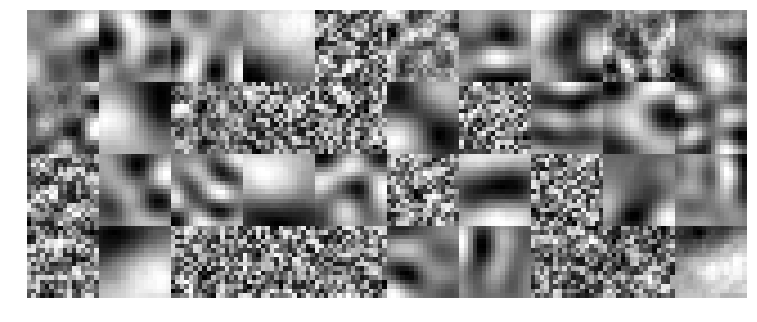

In [173]:
for i in xrange(10000):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.0001)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

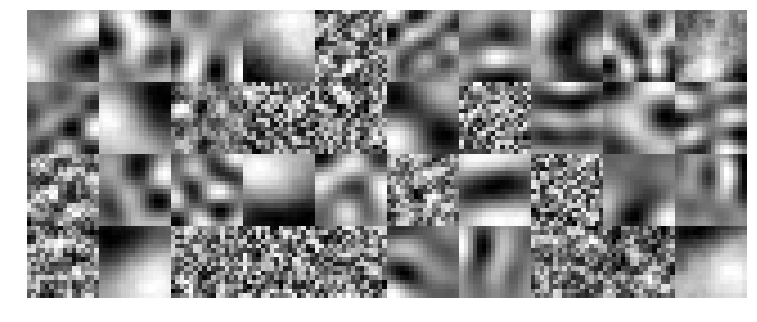

In [174]:
for i in xrange(10000):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.0001)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

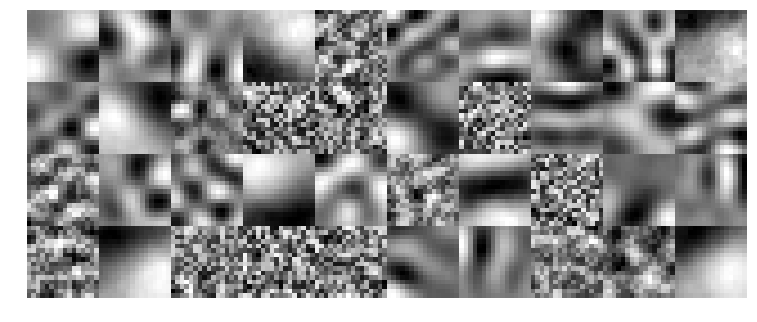

In [175]:
for i in xrange(10000):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.0001)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

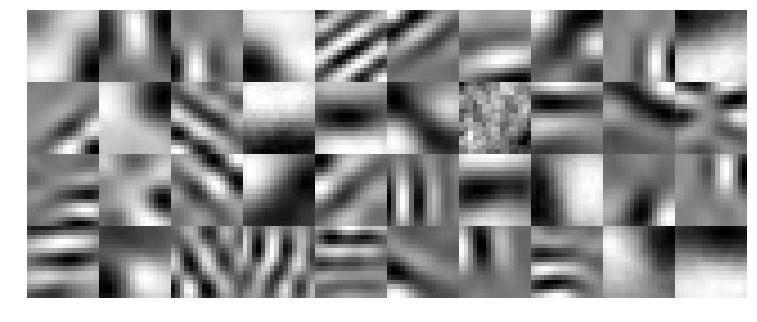

In [184]:
for i in xrange(200000):
    imageNumber = np.random.randint(0,10)
    samplePatches = sample_random_patches(images[:,:,imageNumber], 10, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

    for j in range(len(samplePatches[0,0,:])):
        if j == 0:
            dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
        else:
            dataMatrix = \
            np.column_stack((dataMatrix,\
            samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBook = update_each_atom(dataMatrix, codeBook, allBetaList, allIndexList, stepsize=0.0001)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBook[:,i]).reshape((16,16)),cmap='gray')
    plt.axis('off')

## Qualitative Assessment
After running for 250,000 iterations with 10 images per iterations. The codebook seems to have converged. As you can see in the above picture, there are many forms of edge detectors found in the codebook. However, it seems like with codebook size of 50, there also seems to be a few grating codewords. The edge detectors look quite similar to the codewords presented in class. Let's try reconstructing with this codebook

# Reconstruction of sample patches

In [188]:
# Grabbing sample patches and running regression to get sparse beta

imageNumber = np.random.randint(0,10)
samplePatches = sample_random_patches(images[:,:,imageNumber], 20, 16)

# Reshape the initial codebook
# Number of datapoints (N) = 100
# 
# Each image is 16 x 16 and we'll grab top k values


# Reshape samples into 144 x 1 and add them into a matrix. Final shape should be 256 x 50
# All data are stored in columns (d1 ... dp)

for j in range(len(samplePatches[0,0,:])):
    if j == 0:
        dataMatrix = samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))
    else:
        dataMatrix = \
        np.column_stack((dataMatrix,\
        samplePatches[:,:,j].reshape((len(samplePatches[:,:,j][0]) * len(samplePatches[:,:,j]),1))))

# Create a giant BetaList
allBetaList = []
allIndexList = []
for k in xrange(len(dataMatrix[0])):
    data = np.array([dataMatrix[:,k]]).T
    residual = data
    indexList = []
    betaList = [[0.0] for l in xrange(len(codeBook[0]))]
    for m in xrange(10):
        indexList, betaList, residual = calc_codebook_beta(data, residual, codeBook, indexList, betaList)
    if k == 0:
        allBetaList = np.array(betaList)
        allIndexList.append(indexList)
    else:
        allIndexList.append(indexList)
        allBetaList = np.column_stack((allBetaList, betaList))

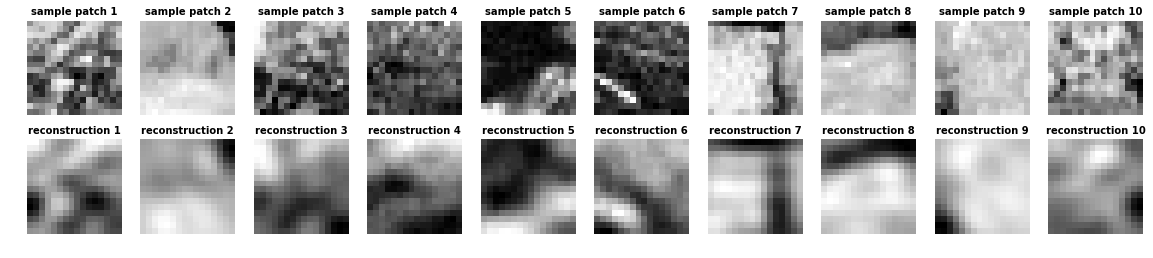

In [208]:
# Sample patch #1
reconstruction = np.dot(codeBook, allBetaList)
plt.figure(figsize=(20,4))
for i in xrange(10):
    plt.subplot(2,10,i+1)
    plt.imshow(np.array(dataMatrix[:,i]).reshape((16,16)), cmap='gray')
    plt.axis('off')
    plt.title('sample patch %s' % (str(i+1)), fontsize=10, fontweight='bold')
for i in xrange(10):
    plt.subplot(2,10,i+11)
    plt.imshow(np.array(reconstruction[:,i]).reshape((16,16)), cmap='gray')
    plt.axis('off')
    plt.title('reconstruction %s' % (str(i+1)), fontsize=10, fontweight='bold')

#### Reconstruction seems to have worked fine. There are features in the sample patches that are probably over characterized for example in sample patch 6, the white line at the bottom left corner seems to have gotten bigger and toned down. On the other hand, the upper right hand gray spots have become whiter in the reconstruction

# Part 2: MNIST Data

In [244]:
#Load MNIST data and initialize spark

spark = SparkSession.builder.appName('mnist').getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')
mnistData = df.rdd.map(lambda x: (x['label'], x['features'])).map(lambda x: np.array(x[1])).collect()
mnistData = np.array(mnistData)


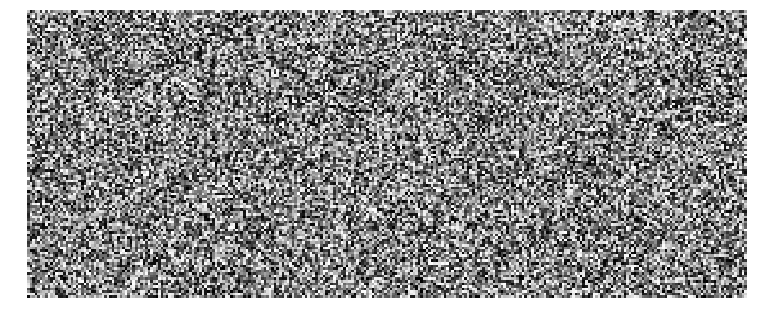

In [251]:
# Initializing a new codebook size 784 x 40
# Plotting the initial codebook 

codeBookMnist = np.random.rand(784,40)
normCodeBookMnist = np.linalg.norm(codeBookMnist, axis=0)
codeBookMnist = codeBookMnist / normCodeBookMnist

#Plot my initial codebook which is 40 of 28 x 28 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBookMnist[:,i]).reshape((28,28)),cmap='gray')
    plt.axis('off')

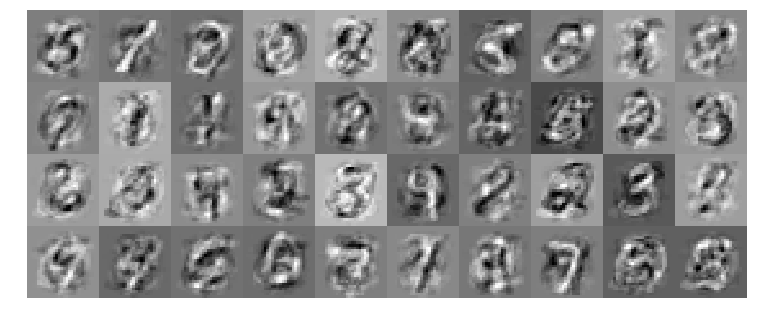

In [259]:
for i in xrange(100000):
# Grabbing 10 images at a time    
    imageNumbers = np.random.randint(0,70000,10)
    sampleMnist = mnistData.T[:,imageNumbers]

# Reshape the initial codebook
# Number of datapoints (N) ~ 10
# Each image is 28 x 28 and we'll grab top k values
    dataMatrix = sampleMnist
    
# Create a giant BetaList
    allBetaList = []
    allIndexList = []
    for k in xrange(len(dataMatrix[0])):
        data = np.array([dataMatrix[:,k]]).T
        residual = data
        indexList = []
        betaList = [[0.0] for l in xrange(len(codeBook[0]))]
        for m in xrange(10):
            indexList, betaList, residual = calc_codebook_beta(data, residual, codeBookMnist, indexList, betaList)
        if k == 0:
            allBetaList = np.array(betaList)
            allIndexList.append(indexList)
        else:
            allIndexList.append(indexList)
            allBetaList = np.column_stack((allBetaList, betaList))
            
    codeBookMnist = update_each_atom(dataMatrix, codeBookMnist, allBetaList, allIndexList, stepsize=0.1)

#Plot codebook which is 50 of 16 x 16 patches.
nrow = 4
ncol = 10

gs = gridspec.GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, top=1.-0.5/(nrow+1),\
                       bottom=0.5/(nrow+1), left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

plt.figure(figsize=(ncol+1 ,nrow+1))

for i in xrange(nrow*ncol):
    plt.subplot(gs[i])
    plt.imshow(np.array(codeBookMnist[:,i]).reshape((28,28)),cmap='gray')
    plt.axis('off')


### Discussion
The codewords in the codebook look similar to what we found from PCA. Since all the digits have some sort of values in the center of the patches, there's an aura in the middle with some features of certain digits. For example, one can see the top left panel displays a 5, and the patch next to it displays something that looks like a 1. Sparse combinations of these codewords can reconstruct a digit, but it seems like the the codebook possibly still has not converged looking at my reconstruction below. However, one can begin to see the digits displayed through reconstruction.

In [260]:
# Grabbing sample patches and running regression to get sparse beta

imageNumbers = np.random.randint(0,70000,10)
sampleMnist = mnistData.T[:,imageNumbers]

# Reshape the initial codebook
# Number of datapoints (N) ~ 10
# Each image is 28 x 28 and we'll grab top k values
dataMatrix = sampleMnist

# Create a giant BetaList
allBetaList = []
allIndexList = []
for k in xrange(len(dataMatrix[0])):
    data = np.array([dataMatrix[:,k]]).T
    residual = data
    indexList = []
    betaList = [[0.0] for l in xrange(len(codeBook[0]))]
    for m in xrange(10):
        indexList, betaList, residual = calc_codebook_beta(data, residual, codeBookMnist, indexList, betaList)
    if k == 0:
        allBetaList = np.array(betaList)
        allIndexList.append(indexList)
    else:
        allIndexList.append(indexList)
        allBetaList = np.column_stack((allBetaList, betaList))

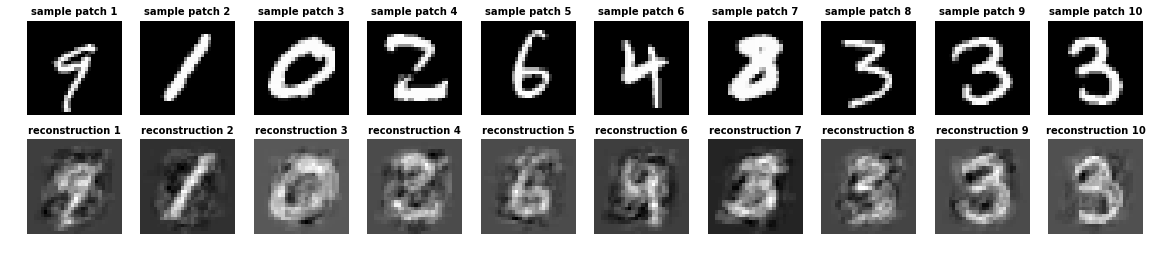

In [261]:
# Sample patch #1
reconstruction = np.dot(codeBookMnist, allBetaList)
plt.figure(figsize=(20,4))
for i in xrange(10):
    plt.subplot(2,10,i+1)
    plt.imshow(np.array(dataMatrix[:,i]).reshape((28,28)), cmap='gray')
    plt.axis('off')
    plt.title('sample patch %s' % (str(i+1)), fontsize=10, fontweight='bold')
for i in xrange(10):
    plt.subplot(2,10,i+11)
    plt.imshow(np.array(reconstruction[:,i]).reshape((28,28)), cmap='gray')
    plt.axis('off')
    plt.title('reconstruction %s' % (str(i+1)), fontsize=10, fontweight='bold')